In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report


In [9]:
df = pd.read_csv("student_depression_dataset.csv")

# Preview
print(df.head())


   id  Gender   Age           City Profession  Academic Pressure  \
0   2    Male  33.0  Visakhapatnam    Student                5.0   
1   8  Female  24.0      Bangalore    Student                2.0   
2  26    Male  31.0       Srinagar    Student                3.0   
3  30  Female  28.0       Varanasi    Student                3.0   
4  32  Female  25.0         Jaipur    Student                4.0   

   Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  \
0            0.0  8.97                 2.0               0.0   
1            0.0  5.90                 5.0               0.0   
2            0.0  7.03                 5.0               0.0   
3            0.0  5.59                 2.0               0.0   
4            0.0  8.13                 3.0               0.0   

        Sleep Duration Dietary Habits   Degree  \
0          '5-6 hours'        Healthy  B.Pharm   
1          '5-6 hours'       Moderate      BSc   
2  'Less than 5 hours'        Healthy       BA   
3     

In [10]:
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Numeric columns
numeric_cols = [
    'Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
    'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress'
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].median())  # fill with median

# Categorical columns
categorical_cols = [
    'Gender', 'City', 'Profession', 'Degree',
    'Sleep Duration', 'Dietary Habits',
    'Have you ever had suicidal thoughts ?',
    'Family History of Mental Illness'
]

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])  # fill with most frequent


In [11]:
# Encode categorical variables
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Encode target variable
df['Depression'] = le.fit_transform(df['Depression'])


In [12]:
# Define features and target
X = df.drop(columns=['id', 'Depression'])
y = df['Depression']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [13]:
# Base models
base_models = [
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
    ('logistic_regression', LogisticRegression(max_iter=500))
]

# Stacking classifier
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=5
)

# Train model
stack_model.fit(X_train, y_train)


StackingClassifier(cv=5,
                   estimators=[('decision_tree',
                                DecisionTreeClassifier(random_state=42)),
                               ('logistic_regression',
                                LogisticRegression(max_iter=500))],
                   final_estimator=LogisticRegression())

In [14]:
# Predictions
y_pred = stack_model.predict(X_test)

# Accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Stacking Model Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


Stacking Model Accuracy: 0.8384
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      2343
           1       0.85      0.87      0.86      3238

    accuracy                           0.84      5581
   macro avg       0.84      0.83      0.83      5581
weighted avg       0.84      0.84      0.84      5581



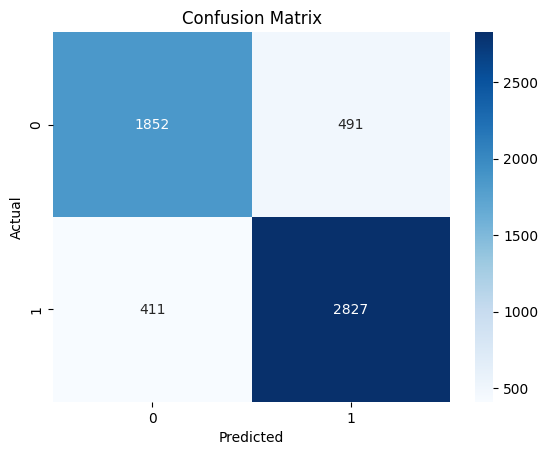

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


                                  Feature  Importance
12  Have you ever had suicidal thoughts ?    0.304238
4                       Academic Pressure    0.131833
6                                    CGPA    0.098770
2                                    City    0.074737
1                                     Age    0.071312
14                       Financial Stress    0.071217
11                                 Degree    0.057775
13                       Work/Study Hours    0.057175
7                      Study Satisfaction    0.040207
9                          Sleep Duration    0.033524
10                         Dietary Habits    0.027387
0                                  Gender    0.016213
15       Family History of Mental Illness    0.015098
3                              Profession    0.000323
8                        Job Satisfaction    0.000192
5                           Work Pressure    0.000000


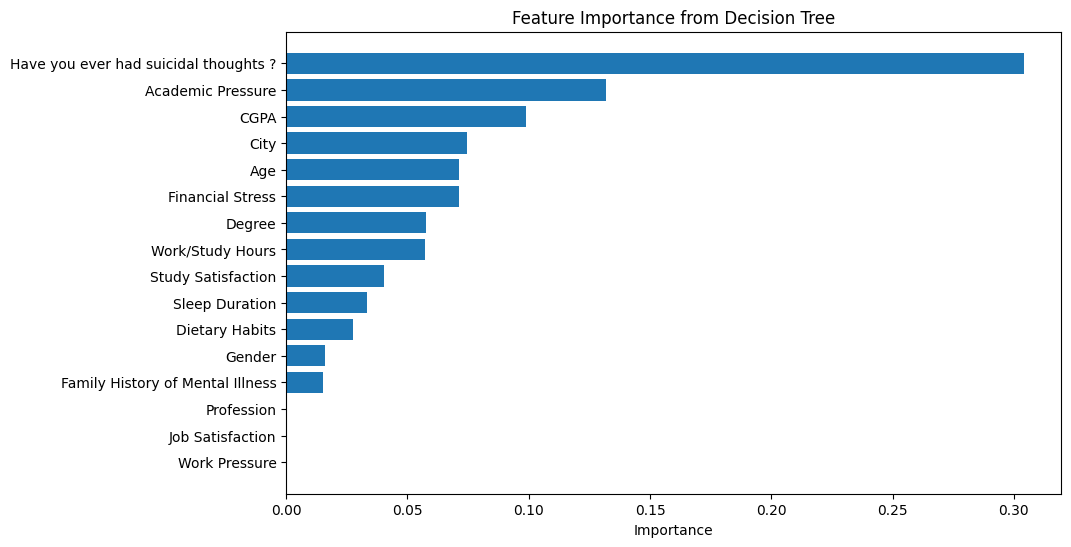

In [17]:
# Decision tree importance
dt_model = stack_model.named_estimators_['decision_tree']
importances = dt_model.feature_importances_
feature_names = X.columns

feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)
print(feat_df)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_df['Feature'], feat_df['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importance from Decision Tree")
plt.gca().invert_yaxis()
plt.show()


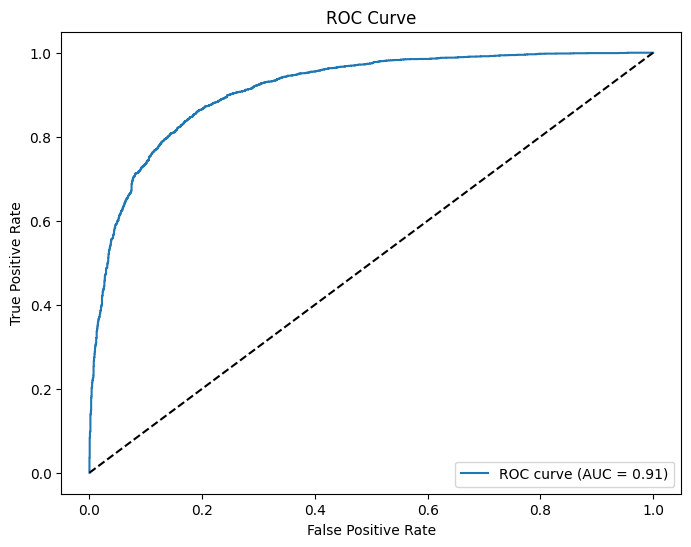

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_prob = stack_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')  # Diagonal baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [20]:
# -------------------------------
# Step 9: Recommendations
# -------------------------------

print("\n=== Recommendations Based on Model Findings ===\n")

recommendations = [
    "1. Prioritize high-risk students showing suicidal thoughts, high academic or financial stress.",
    "2. Launch confidential counseling and wellness programs to support mental health.",
    "3. Introduce academic mentoring and flexible policies to reduce stress from workload.",
    "4. Encourage healthy habits such as balanced sleep, nutrition, and physical activity.",
    "5. Promote mindfulness or meditation sessions to help manage stress.",
    "6. Use anonymous digital surveys to monitor student wellness and provide early interventions.",
    "7. Expand dataset size and diversity to make the predictive model more reliable.",
    "8. Experiment with advanced ML models (Random Forest, XGBoost, Deep Learning) for improved performance."
]

for rec in recommendations:
    print(rec)



=== Recommendations Based on Model Findings ===

1. Prioritize high-risk students showing suicidal thoughts, high academic or financial stress.
2. Launch confidential counseling and wellness programs to support mental health.
3. Introduce academic mentoring and flexible policies to reduce stress from workload.
4. Encourage healthy habits such as balanced sleep, nutrition, and physical activity.
5. Promote mindfulness or meditation sessions to help manage stress.
6. Use anonymous digital surveys to monitor student wellness and provide early interventions.
7. Expand dataset size and diversity to make the predictive model more reliable.
8. Experiment with advanced ML models (Random Forest, XGBoost, Deep Learning) for improved performance.
